# Machine Learning Engineer Nanodegree
## Capstone Project : DeepTesla
Guangwei Wang  
March 20st, 2017

## Definition
### Project Overview

This project is based on Course [MIT 6.S094: Deep Learning for Self-Driving Cars](http://selfdrivingcars.mit.edu/deeptesl/)


### Problem Statement

This project is an end-to-end learning problem. The goal is to predict the steering wheel angel from Tesla dataset based on the video of the forward roadway.

### Datasets and Inputs

Databases with real-traffic video data captured and extracted 10 video clips of highway driving from Tesla:

- The wheel value was extracted from the in-vehicle CAN

- A window from each video frame is cropped/extracted and provide a CSV linking the window to a wheel value.

A snapshot of video frame:
<img src="./images/img/frame_1173.jpg" width = "320" height = "180" align=center />
    
The CSV data format:


|  ts_micro         | frame_index | wheel |
|:-----------------:|:-----------:|:-----:|
|  1464305394391807 | 0           | -0.5  |
| 1464305394425141  | 1           | -0.5  | 
| 1464305394458474  | 2           | -0.5  |


### Evaluation Metrics

This is a regression problem, MSE metrics is adopted here.

$$MSE = \frac{1}{N} \sum_{N}^{i=1}\sqrt{y_{p} - y}$$
where, $y_p$ is the predicted steering wheel angle, $y$ denotes the reference steering wheel angle, and the sample number is `N`. The lower MSE is preferred.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [2]:
# Import local env
import params
import helper
import preprocess

data_dir = params.data_dir
out_dir = params.out_dir
model_dir = params.model_dir

img_height = params.img_height
img_width = params.img_width
img_channels = params.img_channels
batch_size = params.batch_size

### Steering angle info

In [ ]:
import glob
csv_files = glob.glob(os.path.join(data_dir, "*steering.csv"))
steering_csv = pd.concat((pd.read_csv(f) for f in csv_files))

In [ ]:
steering_csv[-3:]

In [ ]:
steering_csv.describe()

In [ ]:
steering_csv.wheel.describe()

In [ ]:
wheel = steering_csv['wheel']
plt.figure
plt.hist(wheel,50);

### Video Info

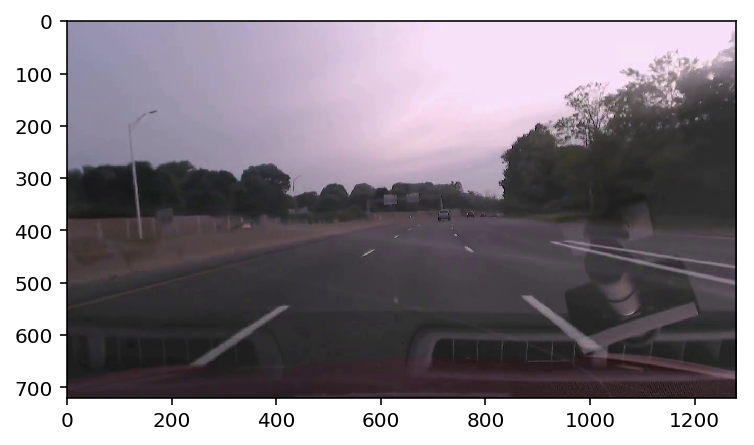

In [3]:
import cv2
import matplotlib.image as mpimg
img=mpimg.imread("images/img/frame_1173.jpg")
imgplot = plt.imshow(img)

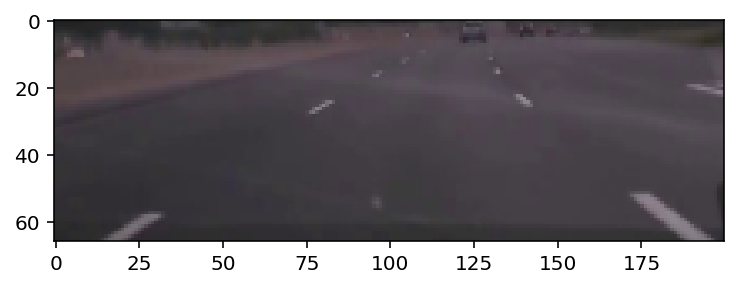

In [4]:
img = preprocess.preprocess(img)
imgplot = plt.imshow(img)

In [5]:
cap = cv2.VideoCapture("epochs/epoch03_front.mkv")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = int(cap.get(cv2.CAP_PROP_FPS))

print (length,width,height,fps)

2702 1280 720 30


The frame count of video is large than csv 2 frame counts

- Merge all frames together with corresponding steering wheel angle.
- Show one frame of the preprocessed data.

## Data Preprocessing 
Load all data together, and then select ~1/10 data as valid data. 

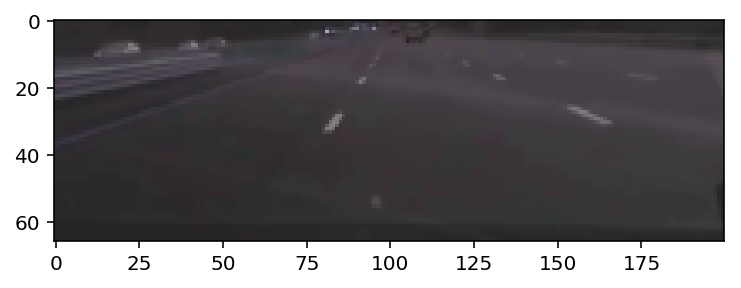

In [3]:
imgs_data, wheels_data = preprocess.load_data('train')
plt.imshow(imgs_data[1])

In [4]:
imgs_data = np.array(imgs_data)

wheels_data = np.array(wheels_data)

wheels_data = np.reshape(wheels_data,(len(wheels_data),1))

In [7]:
wheels_data.shape, imgs_data.shape

((24300, 1), (24300, 66, 200, 3))

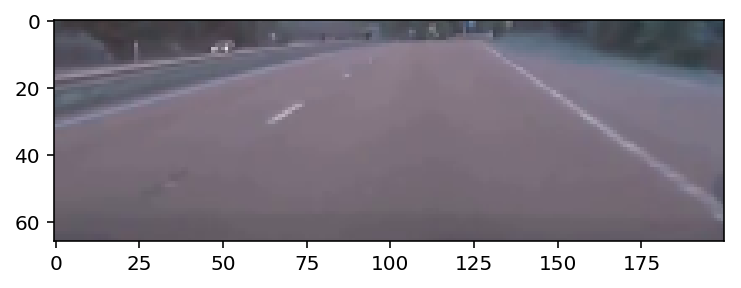

In [5]:
imgs_test, wheels_test = preprocess.load_data('test')
plt.imshow(imgs_test[1])

In [6]:
imgs_test = np.array(imgs_test)
wheels_test = np.array(wheels_test)
wheels_test = np.reshape(wheels_test,(len(wheels_test),1))

In [8]:
imgs_test.shape, wheels_test.shape

((2700, 66, 200, 3), (2700, 1))

In [ ]:
# To do. Save the check point data
# pikle has memory error, hasn't solved

### Keras Implementation

In [9]:
# shuffled and split between train and valid sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imgs_data, wheels_data, test_size=0.2, random_state=42)

In [11]:
# Normalization
# X_train = x_train.astype('float32')
# X_test = x_test.astype('float32')
X_train = X_train / 255.
X_val = X_val / 255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'Valid samples')

X_train shape: (19440, 66, 200, 3)
19440 train samples
4860 Valid samples


In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import losses

Using TensorFlow backend.


In [13]:
epochs = 10
num_classes = 1

In [14]:
model = Sequential()

# Conv layers
model.add(Conv2D(32, (3, 3), padding='same', 
                 activation='relu', 
                 input_shape=(img_height, img_width, img_channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))

In [16]:
model.compile(loss=losses.mean_squared_error, optimizer='Adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 200, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 100, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 98, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 49, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 47040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3010624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [17]:
# Fit the model
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size, 
          shuffle=True)

Train on 19440 samples, validate on 4860 samples
Epoch 1/10
 4224/19440 [=====>........................] - ETA: 242s - loss: 21.1765

KeyboardInterrupt: 

In [77]:
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# save json
json_model = model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
# save model
model.save(model_saved_path)

In [76]:
# Final evaluation of the model
test_scores = model.evaluate(imgs_test, wheels_test, batch_size=128, verbose=1)

print("Test scores: {}".format(test_scores))

2700/2700 [==============================] - 15s     

In [81]:
machine_steering = model.predict(imgs_test, batch_size=128, verbose=0)

2700/2700 [==============================] - 16s     

In [82]:
machine_steering

array([[-18.94664955],
       [-19.03944969],
       [-19.1392765 ],
       ..., 
       [-18.01036453],
       [-18.01393127],
       [-17.91035271]], dtype=float32)

In [95]:
def get_human_steering(epoch_id):
    epoch_dir = params.data_dir
    assert os.path.isdir(epoch_dir)
    steering_path = os.path.join(epoch_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    assert os.path.isfile(steering_path)
    
    rows = pd.read_csv(steering_path)
    human_steering = list(rows.wheel.values)
    return human_steering

In [96]:
human_steering = get_human_steering(10)

In [101]:
np.max(machine_steering)

-16.493267

In [97]:
steering_min = min(np.min(human_steering), np.min(machine_steering))
steering_max = max(np.max(human_steering), np.max(machine_steering))

In [98]:
steering_min

-20.958862

In [99]:
steering_max

3.5

In [105]:
machine_steering[2]

array([-19.1392765], dtype=float32)

## Tensorflow Solution

### Convolution and Max Pooling Layer

In [ ]:
import tensorflow as tf

def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :return: A tensor that represents convolution of x_tensor
    """
    _,_,_,input_depth = x_tensor.get_shape()
    weight = tf.Variable(tf.truncated_normal(*conv_ksize,int(input_depth),conv_num_outputs) 
                                             / np.sqrt(int(x_tensor.get_shape()[1])/2))
                         , name='weight')
    bias = tf.Variable(tf.truncated_normal([conv_num_outputs]), name='bias')
    
    # Apply a convolution, add bias, and add nonlinear activation
    x_tensor = tf.nn.conv2d(x_tensor, 
                            weight, 
                            strides = [1,*conv_strides,1], 
                            padding = 'SAME')
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    return tf.nn.relu(x_tensor)

def max_pool(x_tensor, pool_ksize, pool_strides):
    """
    Apply max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :return: A tensor that represents max pooling of x_tensor
    """
    return tf.nn.max_pool(x_tensor, 
                          ksize = [1,*pool_ksize,1], 
                          strides = [1,*pool_strides,1], 
                          padding = 'SAME')

### Flatten Layer

In [ ]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    # If one component of shape is the special value -1, 
    # the size of that dimension is computed so that the total size remains constant.
    _, size_x, size_y, depth = x_tensor.get_shape()
    return tf.reshape(x_tensor, [-1, int(size_x)*int(size_y)*int(depth)])

### Fully-Connected Layer

In [ ]:
# Weighting Initialization
W = tf.Variable(tf.randn_normal((int(x_tensor.get_shape()[1]),num_outputs))) / np.sqrt(int(x_tensor.get_shape()[1])/2)

In [ ]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs)) 
                         / np.sqrt(int(x_tensor.get_shape()[1])/2))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    y = tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(y)

### Output Layer

In [ ]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs),
                                             mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    return tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)

### Convolutional Model

In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_1 = conv2d(x_tensor=x,
                           conv_num_outputs=24,
                           conv_ksize=[3,3],
                           conv_strides=[1,1])
    conv_1 = max_pool(x_tensor = conv_1,
                      pool_ksize=[3,3],
                      pool_strides=[2,2])
    
    conv_2 = conv2d(x_tensor=conv_1,
                    conv_num_outputs=36,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_2 = max_pool(x_tensor = conv_2,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_3 = conv2d(x_tensor=conv_2,
                    conv_num_outputs=48,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_3 = max_pool(x_tensor = conv_3,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_4 = conv2d(x_tensor=conv_3,
                    conv_num_outputs=64,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_4 = max_pool(x_tensor = conv_4,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    
    fc0 = flatten(conv_4)
    
    fc1 = fully_conn(fc0, 256)     
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, 256)     
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    out = output(fc2, 1)
    return out

In [ ]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32,
                   [None, params.img_height, params.img_width, params.img_channels], 
                   name='x')
y_ = tf.placeholder(tf.float32, [None, 1], name='y_')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')


# Model
y = conv_net(x, keep_prob)
y = tf.identity(y, name='y')

# Lost and Optimizer
loss = tf.reduce_mean(tf.square(tf.subtract(y_, y)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
epochs = 100
batch_size = 128
keep_probability = 0.5

In [ ]:
checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
os.path.isfile(params.model_dir + "model.ckpt.meta")

In [ ]:
os.path.splitext(params.model_dir)[1] == ".ckpt.meta"

In [ ]:
import time
saver = tf.train.Saver()
time_start = time.time()

print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
    loader = tf.train.import_meta_graph(checkpoint_path + '.meta')
    loader.restore(sess, checkpoint_path)
    
    # Training cycle
    for epoch in range(epochs):
        txx, tyy = helper.load_batch_v2(imgs_data[:2000], wheels_data[:2000])
        tyy = np.reshape(tyy,(batch_size,1))
        train_step.run(feed_dict={x: txx, y_: tyy, keep_prob: keep_probability})
        
        
        #for batch_features, batch_targetss in txx, tyy:
        #    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_targets)
        #if (i+1) % 10 == 0:
        #vxx, vyy = imgs_val, wheels_val
        if (epoch+1) % 10 == 0:
            vxx, vyy = imgs_data[-1000:], wheels_data[-1000:]
            vyy = np.reshape(vyy,(len(vyy),1))
            t_loss = loss.eval(feed_dict={x: txx, y_: tyy, keep_prob: 1.0})
            v_loss = loss.eval(feed_dict={x: vxx, y_: vyy, keep_prob: 1.0})
            print ("step {} of {}, train loss {}, val loss {}".format(epoch+1, epochs, t_loss, v_loss))
            
        if (epoch+1) % 100 == 0:
            if not os.path.exists(params.model_dir):
                os.makedirs(params.save_dir)
            checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
            time_end = time.time()
            time_passed = int(round(time_end - time_start))
            print ('Model saved. Time passed: {}s. '.format(time_passed))

## Checkpoint
The model has been saved.

## Test Model

Test the trained model on epoch 10 video.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper, params, preprocess
import random

In [ ]:
imgs_test, wheels_test = preprocess.load_data('test')
plt.imshow(imgs_test[1])

In [ ]:
def test_model():
    '''Test the saved model against the epoch 10 video'''
    with tf.Session() as sess:
    # Initializing the variables
        sess.run(tf.global_variables_initializer())
        checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
        loader = tf.train.import_meta_graph(checkpoint_path + '.meta')
        loader.restore(sess, checkpoint_path)
        
        test_xx, test_yy = helper.load_batch_v2(imgs_test, wheels_test)
        test_yy = np.reshape(test_yy,(batch_size,1))
        test_loss = loss.eval(feed_dict={x: test_xx, y_: test_yy, keep_prob: 1.0})
        print('Testing Loss: {}\n'.format(test_loss))

In [ ]:
test_model()